In [2]:
!pip install ijson transformers torch tqdm matplotlib

In [3]:
import ijson
from collections import defaultdict
from transformers import AutoTokenizer
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# 불필요한 경고 메시지 숨기기
warnings.filterwarnings('ignore')

# ----------------------------------
# (시각화 영문 폰트 설정)
# ----------------------------------
try:
    # Times New Roman 폰트로 설정
    plt.rcParams['font.family'] = 'Times New Roman'
    # (참고: 'Times New Roman' 폰트가 시스템에 설치되어 있어야 합니다.)
    # (만약 폰트가 없을 경우, 'serif'로 대체할 수 있습니다.)
    # plt.rcParams['font.family'] = 'serif'
    
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
    print("Libraries imported. Font set to 'Times New Roman'.")
except Exception as e:
    print(f"Warning: Failed to set 'Times New Roman'. Default font will be used. Error: {e}")
    pass

Libraries imported. Font set to 'Times New Roman'.


In [4]:
# --- ⚙️ Settings ---

# 1. JSON file paths
TRAIN_FILE_PATH = "dataset_train.json"
TEST_FILE_PATH = "dataset_test.json"

# 2. Text field name within JSON
TEXT_FIELD_NAME = "text" 

# 3. Tokenizer model name
TOKENIZER_NAME = "bert-base-multilingual-cased" 

# 4. Token count bin size
BIN_SIZE = 50

# 5. JSON structure prefix (e.g., 'item' for [...])
JSON_PREFIX = 'item'

# -----------------------------------

print(f"Settings loaded. Train: '{TRAIN_FILE_PATH}', Test: '{TEST_FILE_PATH}'")
print(f"Tokenizer: '{TOKENIZER_NAME}'")

Settings loaded. Train: 'dataset_train.json', Test: 'dataset_test.json'
Tokenizer: 'bert-base-multilingual-cased'


In [5]:
def analyze_token_distribution(file_path, tokenizer, json_prefix, text_field, bin_size):
    """
    Analyzes token distribution for a large JSON file via ijson streaming.
    Returns a defaultdict of bin_counts.
    """
    
    bin_counts = defaultdict(int)
    processed_items = 0
    
    print(f"\n[{file_path}] Analysis started...")
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            items_iterator = ijson.items(f, json_prefix)
            
            for data in tqdm(items_iterator, desc=f"Processing: {file_path}", unit=" items"):
                try:
                    if text_field not in data or not isinstance(data[text_field], str):
                        continue

                    text = data[text_field]
                    token_count = len(tokenizer.encode(text, add_special_tokens=True))
                    
                    bin_start = (token_count // bin_size) * bin_size
                    bin_label = f"{bin_start}~{bin_start + bin_size}"
                    
                    bin_counts[bin_label] += 1
                    processed_items += 1
                    
                except Exception as e:
                    print(f"Error processing item: {e}", file=sys.stderr)

    except FileNotFoundError:
        print(f"Error: File not found. '{file_path}'", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Critical file error: {e}", file=sys.stderr)
        return None

    print(f"[{file_path}] Processing complete! (Total {processed_items} items)")
    
    return bin_counts

print("Analysis function (analyze_token_distribution) defined.")

Analysis function (analyze_token_distribution) defined.


In [6]:
# 1. Load tokenizer (only once)
print(f"Loading tokenizer: '{TOKENIZER_NAME}'...")
try:
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
    print("Tokenizer loaded successfully.")
except Exception as e:
    print(f"Fatal Error: Failed to load tokenizer. {e}")
    tokenizer = None

train_bin_counts = None
test_bin_counts = None

if tokenizer:
    # 2. Analyze Train file
    train_bin_counts = analyze_token_distribution(
        TRAIN_FILE_PATH, tokenizer, JSON_PREFIX, TEXT_FIELD_NAME, BIN_SIZE
    )
    
    # 3. Analyze Test file
    test_bin_counts = analyze_token_distribution(
        TEST_FILE_PATH, tokenizer, JSON_PREFIX, TEXT_FIELD_NAME, BIN_SIZE
    )

    # 4. Print text summary
    if train_bin_counts:
        print("\n--- 📊 Train Set Distribution (Text Summary) ---")
        sorted_train = sorted(train_bin_counts.items(), key=lambda i: int(i[0].split('~')[0]))
        total_count = 0
        for label, count in sorted_train:
            print(f"{label} tokens: {count} items")
            total_count += count
        print(f"---------------------------------\nTotal Train Items: {total_count}")


    if test_bin_counts:
        print("\n--- 📊 Test Set Distribution (Text Summary) ---")
        sorted_test = sorted(test_bin_counts.items(), key=lambda i: int(i[0].split('~')[0]))
        total_count = 0
        for label, count in sorted_test:
            print(f"{label} tokens: {count} items")
            total_count += count
        print(f"---------------------------------\nTotal Test Items: {total_count}")
else:
    print("Analysis cannot proceed. Tokenizer was not loaded.")

Loading tokenizer: 'bert-base-multilingual-cased'...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Tokenizer loaded successfully.

[dataset_train.json] Analysis started...


Processing: dataset_train.json: 0 items [00:00, ? items/s]Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors
Processing: dataset_train.json: 10792 items [00:14, 729.99 items/s]


[dataset_train.json] Processing complete! (Total 10792 items)

[dataset_test.json] Analysis started...


Processing: dataset_test.json: 2500 items [00:02, 930.68 items/s] 

[dataset_test.json] Processing complete! (Total 2500 items)

--- 📊 Train Set Distribution (Text Summary) ---
50~100 tokens: 7 items
100~150 tokens: 52 items
150~200 tokens: 190 items
200~250 tokens: 329 items
250~300 tokens: 580 items
300~350 tokens: 724 items
350~400 tokens: 837 items
400~450 tokens: 929 items
450~500 tokens: 1055 items
500~550 tokens: 929 items
550~600 tokens: 928 items
600~650 tokens: 884 items
650~700 tokens: 795 items
700~750 tokens: 690 items
750~800 tokens: 553 items
800~850 tokens: 359 items
850~900 tokens: 257 items
900~950 tokens: 136 items
950~1000 tokens: 104 items
1000~1050 tokens: 72 items
1050~1100 tokens: 46 items
1100~1150 tokens: 35 items
1150~1200 tokens: 24 items
1200~1250 tokens: 37 items
1250~1300 tokens: 20 items
1300~1350 tokens: 26 items
1350~1400 tokens: 15 items
1400~1450 tokens: 20 items
1450~1500 tokens: 17 items
1500~1550 tokens: 26 items
1550~1600 tokens: 17 items
1600~1650 tokens: 13 items
1650~1700 tokens: 16 items
1700~1750 tokens: 8 i

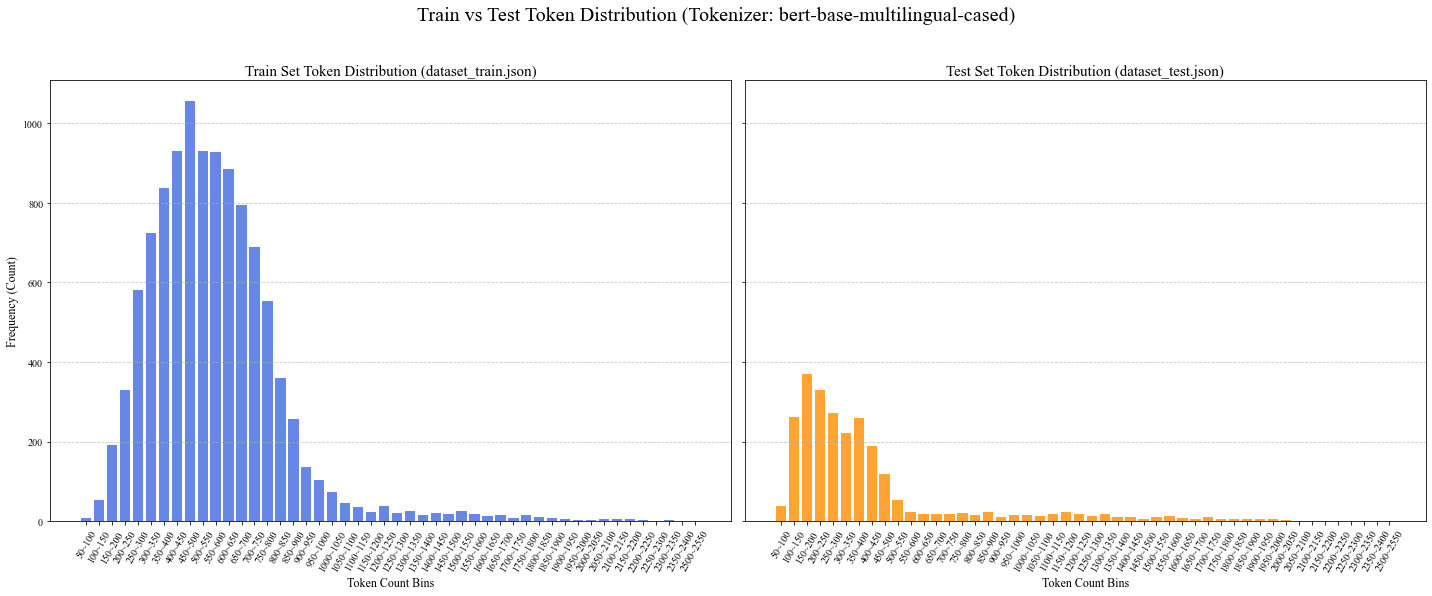

In [7]:
# Use the results from Cell 5 (train_bin_counts and test_bin_counts)

if train_bin_counts and test_bin_counts:
    
    # 1. Combine all unique labels from both sets to unify the X-axis
    all_labels_set = set(train_bin_counts.keys()) | set(test_bin_counts.keys())
    
    # 2. Sort labels numerically
    sorted_labels = sorted(
        list(all_labels_set), 
        key=lambda item: int(item.split('~')[0])
    )
    
    # 3. Create count lists based on sorted labels (using 0 for missing bins)
    train_plot_counts = [train_bin_counts.get(label, 0) for label in sorted_labels]
    test_plot_counts = [test_bin_counts.get(label, 0) for label in sorted_labels]

    # 4. Create subplots (1 row, 2 columns, sharing Y-axis)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    
    # ---------------------------------
    # ax1 : Train Set Plot
    # ---------------------------------
    ax1.bar(sorted_labels, train_plot_counts, color='royalblue', alpha=0.8, label='Train')
    ax1.set_title(f'Train Set Token Distribution ({TRAIN_FILE_PATH})', fontsize=15)
    ax1.set_xlabel('Token Count Bins', fontsize=12)
    ax1.set_ylabel('Frequency (Count)', fontsize=12)
    ax1.tick_params(axis='x', rotation=60) # Rotate x-axis labels
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # ---------------------------------
    # ax2 : Test Set Plot
    # ---------------------------------
    ax2.bar(sorted_labels, test_plot_counts, color='darkorange', alpha=0.8, label='Test')
    ax2.set_title(f'Test Set Token Distribution ({TEST_FILE_PATH})', fontsize=15)
    ax2.set_xlabel('Token Count Bins', fontsize=12)
    ax2.tick_params(axis='x', rotation=60)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # 5. Set main title and layout
    fig.suptitle(f'Train vs Test Token Distribution (Tokenizer: {TOKENIZER_NAME})', 
                 fontsize=20, y=1.03)
    plt.tight_layout()
    
    # 6. Show the plot
    plt.show()

else:
    print("Cannot visualize. Data is missing (analysis might have failed).")

In [12]:
import ijson
import json  # JSON 파일 저장을 위해 기본 'json' 라이브러리 임포트
from decimal import Decimal # (수정) Decimal 객체 임포트
from collections import defaultdict
from transformers import AutoTokenizer
import sys
from tqdm import tqdm
import warnings

# 불필요한 경고 메시지 숨기기
warnings.filterwarnings('ignore')

print("필요한 라이브러리를 임포트했습니다 (Decimal 포함).")

필요한 라이브러리를 임포트했습니다 (Decimal 포함).


In [13]:
# --- ⚙️ 설정 ---

# 1. 원본 JSON 파일 경로
TRAIN_FILE_PATH = "dataset_train.json"
TEST_FILE_PATH = "dataset_test.json"

# 2. 새로 생성할 (필터링된) JSON 파일 경로
OUTPUT_TRAIN_FILE = "dataset_train_under250.json"
OUTPUT_TEST_FILE = "dataset_test_under250.json"

# 3. 토큰 분석 기준
TOKENIZER_NAME = "bert-base-multilingual-cased" 
TEXT_FIELD_NAME = "text" 
JSON_PREFIX = 'item' # [ ... ] 구조이므로 'item'

# 4. 필터링할 최대 토큰 수 (이 값 *이하*)
MAX_TOKEN_LIMIT = 250

# -----------------------------------

print(f"설정 완료. {MAX_TOKEN_LIMIT} 토큰 이하의 데이터를 필터링합니다.")
print(f"Train 결과물: {OUTPUT_TRAIN_FILE}")
print(f"Test 결과물: {OUTPUT_TEST_FILE}")

설정 완료. 250 토큰 이하의 데이터를 필터링합니다.
Train 결과물: dataset_train_under250.json
Test 결과물: dataset_test_under250.json


In [14]:
# (추가) Decimal 객체를 float으로 변환해주는 커스텀 인코더 정의
class CustomJSONEncoder(json.JSONEncoder):
    """
    Decimal 객체를 JSON이 저장할 수 있는 float으로 변환합니다.
    """
    def default(self, obj):
        if isinstance(obj, Decimal):
            return float(obj)
        # 그 외의 경우는 기본 인코더에 맡깁니다.
        return super(CustomJSONEncoder, self).default(obj)

def filter_json_by_token_count(input_file, output_file, tokenizer, max_limit, json_prefix, text_field):
    """
    ijson으로 JSON 파일을 스트리밍하며, max_limit 토큰 이하인 항목만
    리스트에 담아 새로운 JSON 파일로 저장합니다. (Decimal 변환기 포함)
    """
    
    print(f"\n--- 처리 시작: {input_file} ---")
    
    filtered_data_list = []
    
    try:
        with open(input_file, 'r', encoding='utf-8') as f:
            items_iterator = ijson.items(f, json_prefix)
            
            for data in tqdm(items_iterator, desc=f"{input_file} 필터링 중", unit="개"):
                try:
                    if text_field not in data or not isinstance(data[text_field], str):
                        continue
                    
                    text = data[text_field]
                    token_count = len(tokenizer.encode(text, add_special_tokens=True))
                    
                    if token_count <= max_limit:
                        filtered_data_list.append(data)
                        
                except Exception as e:
                    # (토크나이저 512 경고는 무시하고, 다른 오류만 출력)
                    if "Sequence length" not in str(e):
                        print(f"항목 처리 중 오류 발생: {e}", file=sys.stderr)

    except FileNotFoundError:
        print(f"오류: 원본 파일을 찾을 수 없습니다. '{input_file}'", file=sys.stderr)
        return
    except Exception as e:
        print(f"파일 읽기 중 심각한 오류 발생: {e}", file=sys.stderr)
        return

    print(f"필터링 완료. 총 {len(filtered_data_list)}개의 항목을 찾았습니다.")

    # 4. 리스트에 모인 데이터를 새 JSON 파일로 저장
    try:
        print(f"파일 저장 중... -> {output_file}")
        with open(output_file, 'w', encoding='utf-8') as f:
            
            # (수정) cls=CustomJSONEncoder 인자를 추가하여 Decimal 오류 해결
            json.dump(filtered_data_list, f, 
                      ensure_ascii=False, 
                      indent=2, 
                      cls=CustomJSONEncoder) # <-- 이 부분이 추가되었습니다!
            
        print(f"성공: '{output_file}' 파일이 생성되었습니다.")
        
    except Exception as e:
        print(f"오류: 출력 파일 '{output_file}' 저장 중 오류 발생: {e}", file=sys.stderr)


print("파일 필터링 함수(filter_json_by_token_count) 및 커스텀 인코더 정의 완료.")

파일 필터링 함수(filter_json_by_token_count) 및 커스텀 인코더 정의 완료.


In [15]:
# 1. 토크나이저 로드 (한 번만)
print(f"'{TOKENIZER_NAME}' 토크나이저를 로드합니다...")
try:
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
    print("토크나이저 로드 완료.")
except Exception as e:
    print(f"치명적 오류: 토크나이저 로드 실패. {e}")
    tokenizer = None # 실패 시 tokenizer를 None으로 설정

if tokenizer:
    # 2. Train 파일 필터링 실행
    filter_json_by_token_count(
        TRAIN_FILE_PATH,
        OUTPUT_TRAIN_FILE,
        tokenizer,
        MAX_TOKEN_LIMIT,
        JSON_PREFIX,
        TEXT_FIELD_NAME
    )
    
    # 3. Test 파일 필터링 실행
    filter_json_by_token_count(
        TEST_FILE_PATH,
        OUTPUT_TEST_FILE,
        tokenizer,
        MAX_TOKEN_LIMIT,
        JSON_PREFIX,
        TEXT_FIELD_NAME
    )
    
    print("\n--- 모든 파일 필터링 작업이 완료되었습니다. ---")

else:
    print("토크나이저 로드에 실패하여 작업을 진행할 수 없습니다.")

'bert-base-multilingual-cased' 토크나이저를 로드합니다...
토크나이저 로드 완료.

--- 처리 시작: dataset_train.json ---


dataset_train.json 필터링 중: 0개 [00:00, ?개/s]Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors
dataset_train.json 필터링 중: 10792개 [00:15, 675.54개/s]


필터링 완료. 총 582개의 항목을 찾았습니다.
파일 저장 중... -> dataset_train_under250.json
성공: 'dataset_train_under250.json' 파일이 생성되었습니다.

--- 처리 시작: dataset_test.json ---


dataset_test.json 필터링 중: 2500개 [00:02, 888.92개/s]


필터링 완료. 총 1007개의 항목을 찾았습니다.
파일 저장 중... -> dataset_test_under250.json
성공: 'dataset_test_under250.json' 파일이 생성되었습니다.

--- 모든 파일 필터링 작업이 완료되었습니다. ---
